# CHALLENGE PROBLEM 1 — (Sergio) Version 1

# Instructions


[IMPORTANT] In this project three constraints are set for you:
<ul>
    <li><b>Distance: </b>Any mechanisms output with a distance to the target curve larger than 0.75 will be considered invalid and will not be used to calculate the score of the submissions.</li>
    <li><b>Material Use: </b>Any mechanism with total linkage lengths more than 10.0 will be deemed invalid and will not be used to calculate the score of the submissions.</li>
    <li><b>Mechanism Complexity: </b>For this project we want you to generate mechanisms with no more than 20 joints </li>
</ul>

Submitted mechanisms that violate these constraints will not be scored.

Your performance on the targets will be measured based on the hypervolume calculated from the population with a reference point of 0.75 for distance and 10.0 for material use. Note that we limit the number of mechanisms you are permitted to submit as potential solutions for any given curve to 1000. The closer you get to ideal the higher the score you will receive. The total score for your submission will be the average hypervolume for all target curves.

# LOG

1. Cleaned the advance notebook to be more streamed-lined (SM)  
2. Parametriced the curve to run all optimizations by updating the curve (SM)  
3. Added a 'Compare and Save Improved Solutions' (SM)  
   - Compares the hypervolume of the new set of solutions to the previous hypervolume, then save only if the new solutions are better for that curve. (incremental improvement)

# TO-DO

1. Add the complete instructions
2. Make GD be a function of both material and distance
3. Use GA to make mechanisms
4. Modify GA mutations and Cross-overs

# Official Hints:
- Why not do some preprocessing to random mechanisms before running GA?
- Can you use the gradients of both functions in gradient based optimization? 
- Can you cycle through multiple optimization runs?
- Can you mix different kinds of GA? We showed how GA can be used for a single mechanism skeleton and how it can be used to also create the mechanisms?
- Can you modify the GA mutations and cross-over?
- Is there a more efficient representation of mechanisms we can use?
- Are there smarter gradient-based optimization methods?

# 1. SETUP!

Target Optimization Curve

In [260]:
# --- Configurable target curve ---
curve_index = 5   # 0-based index: 0 = Problem 1, 1 = Problem 2, ..., 5 = Problem 6

a. Environment Setup

In [261]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"  # Disable GPU for JAX (Remove if you want to use GPU)

import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm, trange

# deteministic random numbers
np.random.seed(0)
random.seed(0)

b. Load Tarject Cruves

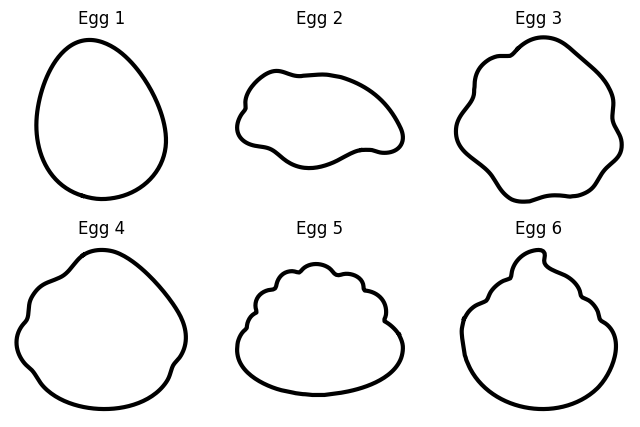

In [262]:
target_curves = np.load('target_curves.npy')

# Plot all target curves

# Initialize a 2x3 subplot for plotting all target curves
fig, axs = plt.subplots(2, 3, figsize=(8, 5))

# Loop through the 6 target curves to plot them
for i in range(6):
    # Extract x and y coordinates from the target curve
    x_coords = np.array(target_curves[i])[:, 0]
    y_coords = np.array(target_curves[i])[:, 1]

    # Plot the curve on the respective subplot
    axs[i // 3, i % 3].plot(x_coords, y_coords, color='black', linewidth=3)

    # Set title for each subplot
    axs[i // 3, i % 3].set_title(f'Egg {i + 1}')

    # Ensure equal scaling for x and y axes
    axs[i // 3, i % 3].axis('equal')
    axs[i // 3, i % 3].axis('off')


c. Optimization Imports

In [263]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling, Sampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize

from LINKS.Optimization import DifferentiableTools, Tools

d. Problem Definition (Tools + Pymoo class)

In [264]:
PROBLEM_TOOLS = Tools( # we have to define this outside the class due to pymoo deepcopy limitations
            device='cpu' # device to run the optimization on
        )  
PROBLEM_TOOLS.compile() # compile the functions for faster runs

class mechanism_synthesis_optimization(ElementwiseProblem):

    # When intializing, set the mechanism size and target curve
    def __init__(self, target_curve, N = 5):
        self.N = N
        variables = dict()

        # The upper triangular portion of our NxN Connectivity Matrix consists of Nx(N-1)/2 boolean variables:
        for i in range(N):
            for j in range(i):
                variables["C" + str(j) + "_" + str(i)] = Binary()

        # We Delete C0_1 since we know node 1 is connected to the motor
        del variables["C0_1"]

        #Our position matrix consists of Nx2 real numbers (cartesian coordinate values) between 0 and 1
        for i in range(2*N):
            variables["X0" + str(i)] = Real(bounds=(0.0, 1.0))

        # Our node type vector consists of N boolean variables (fixed vs non-fixed)
        for i in range(N):
            variables["fixed_nodes" + str(i)] =  Binary(N)

        # Our target node is an integer between 1 and N-1, (any except the motor node).
        variables["target"] = Integer(bounds=(1,N-1))

        # Set up some variables in the problem class we inherit for pymoo
        # n_obj=number of objectives, n_constr=number of constraints
        # Our objectives are chamfer distance and material, and they both have constraints.
        super().__init__(vars=variables, n_obj=2, n_constr=2)

        # Store the target curve point cloud
        self.target_curve = target_curve


    def convert_1D_to_mech(self, x):
        N = self.N

        # Get target joints index
        target_idx = x["target"]

        # Build connectivity matrix from its flattened constitutive variables
        C = np.zeros((N,N))
        x["C0_1"] = 1

        for i in range(N):
            for j in range(i):
                # C[i,j] = x["C" + str(j) + "_" + str(i)]
                C[j,i] = x["C" + str(j) + "_" + str(i)]

        edges = np.array(np.where(C==1)).T
        
        # Reshape flattened position matrix to its proper Nx2 shape
        x0 = np.array([x["X0" + str(i)] for i in range(2*N)]).reshape([N,2])

        # Extract a list of Nodes that are fixed from boolean fixed_nodes vector
        fixed_joints = np.where(np.array([x["fixed_nodes" + str(i)] for i in range(N)]))[0].astype(int)

        #We fix the motor and original ground node as 0 and 1 respectively in this implementation
        motor=np.array([0,1])

        return x0, edges, fixed_joints, motor, target_idx

    def convert_mech_to_1D(self, x0, edges, fixed_joints, target_idx=None, **kwargs):
        # This function assumes motor to be [0, 1] our random mechanism generator automatically does this
        N = self.N

        # Initialize dictionary to store 1D representation of mechanism
        x = {}

        # Store target node value
        if target_idx is None:
            target_idx = x0.shape[0]-1 # Assume last node is the target if not specified
            
        x["target"] = target_idx

        # Store connectivity matrix in its flattened form
        C = np.zeros((N,N), dtype=bool)
        C[edges[:,0], edges[:,1]] = 1
        C[edges[:,1], edges[:,0]] = 1
       
        for i in range(N):
            for j in range(i):
                x["C" + str(j) + "_" + str(i)] = C[i,j]

        del x["C0_1"]
        
        # Store position matrix in its flattened form
        if x0.shape[0] != N:
            x0 = np.pad(x0, ((0, N - x0.shape[0]), (0, 0)), 'constant', constant_values=0)
            
        for i in range(2*N):
            x["X0" + str(i)] = x0.flatten()[i]

        # Store fixed nodes in boolean vector form
        for i in range(N):
            x["fixed_nodes" + str(i)] = (i in fixed_joints) or (i>=N)

        return x

    def _evaluate(self, x, out, *args, **kwargs):
        #Convert to mechanism representation
        x0, edges, fixed_joints, motor, target_idx = self.convert_1D_to_mech(x)
        
        # Simulate
        distance, material = PROBLEM_TOOLS(x0,
                                edges,
                                fixed_joints,
                                motor,
                                self.target_curve,
                                target_idx=target_idx
                            )

        out["F"] = np.array([distance, material])
        out["G"] = out["F"] - np.array([0.75, 10.0])  # Constraints: distance <= 0.75, material <= 10.0


# 2. Initial Population

a. Initial population - Randomized

In [ ]:
from LINKS.Optimization import MechanismRandomizer
from LINKS.Visualization import MechanismVisualizer

randomizer = MechanismRandomizer(
    min_size = 6, # smalllest mechanism to sample
    max_size = 14, # largest mechanism to sample
    device='cpu')

visualizer = MechanismVisualizer()

# Now let's generate 100 mechanisms of size 7 and initilize a population for optimization
mechanisms = [randomizer(n=7) for _ in range(100)] #yeah

# 3. GA Optimization

b. GA Optimization Setup

In [266]:
problem = mechanism_synthesis_optimization(target_curves[curve_index], N=7)

initial_population = [problem.convert_mech_to_1D(**mech) for mech in mechanisms]

class sample_from_random(Sampling):
        def _do(self, problem, n_samples, **kwargs):
                return np.array([initial_population[i%len(initial_population)] for i in range(n_samples)])

F = problem.evaluate(np.array(initial_population))[0]
print(f'Best Distance Performance In random population: {F[:,0].min()}')
print(f'Best Material Performance In random population: {F[:,1].min()}')

Best Distance Performance In random population: 1.1201430559158325
Best Material Performance In random population: 5.041465759277344


c. GA Optimization

In [267]:
algorithm = NSGA2(pop_size=100,
                  sampling=sample_from_random(),
                  mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                  mutation=PolynomialMutation(prob=0.5),
                  eliminate_duplicates=MixedVariableDuplicateElimination())

results = minimize(problem,
                algorithm,
                ('n_gen', 100),
                verbose=True,
                save_history=True,
                seed=123
                )

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  0.5032740831 |  9.3229527187 |             - |             -
     2 |      200 |      1 |  0.5032740831 |  7.8668462682 |             - |             -
     3 |      300 |      1 |  0.5032740831 |  7.0790119767 |             - |             -
     4 |      400 |      1 |  0.5032740831 |  6.2569662237 |             - |             -
     5 |      500 |      1 |  0.5032740831 |  5.7842779756 |             - |             -
     6 |      600 |      1 |  0.5032740831 |  4.8983974504 |             - |             -
     7 |      700 |      1 |  0.5032740831 |  4.3355570304 |             - |             -
     8 |      800 |      1 |  0.5032740831 |  4.0149619257 |             - |             -
     9 |      900 |      1 |  0.5032740831 |  3.8016345060 |             - |             -
    10 |     1000 |      1 |  0.5032740831 |  3.7607729328 |             - |             -

d. Hypervolume Check

Hyper Volume ~ 1.890236


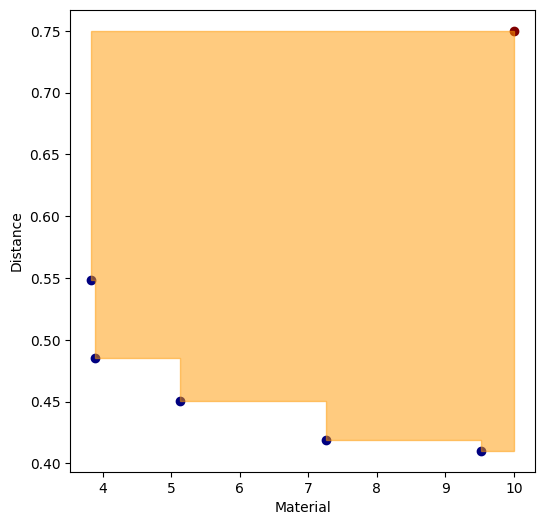

In [268]:
from LINKS.Visualization import GAVisualizer
from LINKS.Kinematics import MechanismSolver
from LINKS.Geometry import CurveEngine
from pymoo.indicators.hv import HV
ga_visualizer = GAVisualizer()
solver = MechanismSolver(device='cpu')
curve_engine = CurveEngine(device='cpu')

if not results.X is None:
    #Specify reference point
    ref_point = np.array([0.75, 10.0])

    #Calculate Hypervolume
    ind = HV(ref_point)
    hypervolume = ind(results.F)

    #Print and plot
    print('Hyper Volume ~ %f' %(hypervolume))
    ga_visualizer.plot_HV(results.F, ref_point, objective_labels=['Distance', 'Material']) #use the plot_HV function from utils
else:
    print('Did Not Find Solutions!!')

# 4. GD Optimization

a. GD Setup

In [269]:
from LINKS.Optimization import DifferentiableTools

differentiable_optimization_tools = DifferentiableTools(
    device='cpu' # device to run the optimization on
)  
differentiable_optimization_tools.compile() # compile the functions for faster runs

# lets make a batch from our GA results
x0s = []
edges = []
fixed_joints = []
motors = []
target_idxs = []
if not results.X is None:
    if not isinstance(results.X, dict):
        for i in range(results.X.shape[0]):
            x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member  = problem.convert_1D_to_mech(results.X[i])
            x0s.append(x0_member)
            edges.append(edges_member)
            fixed_joints.append(fixed_joints_member)
            motors.append(motor_member)
            target_idxs.append(target_idx_member)
    else:
        x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member  = problem.convert_1D_to_mech(results.X)
        x0s.append(x0_member)
        edges.append(edges_member)
        fixed_joints.append(fixed_joints_member)
        motors.append(motor_member)
        target_idxs.append(target_idx_member)

distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
    x0s,
    edges,
    fixed_joints,
    motors,
    target_curves[curve_index],
    target_idxs
)

# print(materials, distances)

GD Optimization - distance-based

In [270]:
x = x0s.copy()

step_size = 4e-4
n_steps = 1000

# keep track of which members are done optimizing
done_optimizing = np.zeros(len(x), dtype=bool)

x_last = x.copy()

for step in trange(n_steps):
    
    # get current distances, materials and gradients
    distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
        x,
        edges,
        fixed_joints,
        motors,
        target_curves[curve_index],
        target_idxs
    )
    
    # only update members that are valid and not done optimizing
    valids = np.where(np.logical_and(distances <= 0.75, materials <= 10.0))[0]
    invalids = np.where(~np.logical_and(distances <= 0.75, materials <= 10.0))[0]
    
    # if a member is invalid, revert to last step and mark as done optimizing
    for i in invalids:
        done_optimizing[i] = True
        x[i] = x_last[i]
    
    # keep a copy of last step
    x_last = x.copy()
    
    # update valid members
    for i in valids:
        if done_optimizing[i]:
            continue
        x[i] = x[i] - step_size * distance_grads[i]
        
    if np.all(done_optimizing):
        print(f'All members are done optimizing at step {step}')
        break

  0%|          | 0/1000 [00:00<?, ?it/s]

Combination of populations

In [271]:
combined_x0s = x0s + x
combined_edges = edges + edges
combined_fixed_joints = fixed_joints + fixed_joints
combined_motors = motors + motors
combined_target_idxs = target_idxs + target_idxs


# 5. Compare and Save Improved Solutions (per curve)

In [272]:
# === Parametric per-curve updater (uses curve_index) =======================
# Requires: a variable `curve_index` defined earlier (0..5).
# Behavior: builds a candidate list (combined_* preferred; else results.X),
# evaluates ONLY Problem {curve_index+1} against what's saved in my_submission.npy,
# and replaces that problem if the candidate scores higher. Other problems untouched.

import os, time
import numpy as np
from LINKS.CP import make_empty_submission, evaluate_submission

# ----- Config -----
submission_path = "my_submission.npy"
per_problem_cap = 1000
require_margin = 1e-12  # minimal improvement to count as "better"

# ----- Helpers -----
def load_submission(path=submission_path):
    if os.path.exists(path):
        return np.load(path, allow_pickle=True).item()
    return make_empty_submission()

def save_submission(sub, path=submission_path):
    # tiny safety: timestamped backup before overwrite
    if os.path.exists(path):
        ts = time.strftime("%Y%m%d-%H%M%S")
        bak = path.replace(".npy", f".{ts}.bak.npy")
        np.save(bak, np.load(path, allow_pickle=True))
        print(f"[backup] {bak}")
    np.save(path, sub)

def cap_list(lst, limit=per_problem_cap):
    return lst[:limit]

def to_mech_list(x0s, edges, fixed_joints, motors, target_idxs):
    out = []
    for x0, e, fj, m, t in zip(x0s, edges, fixed_joints, motors, target_idxs):
        out.append({"x0": x0, "edges": e, "fixed_joints": fj, "motor": m, "target_joint": t})
    return out

def score_only_curve(mech_list, curve_1based):
    tmp = make_empty_submission()
    key = f"Problem {curve_1based}"
    tmp[key] = mech_list
    res = evaluate_submission(tmp)
    return res["Score Breakdown"][key]

# ----- Build candidate list for THIS curve -----
# Prefer your combined (post-GD) set if present, else convert results.X via your problem.
try:
    candidate_list = to_mech_list(
        combined_x0s, combined_edges, combined_fixed_joints, combined_motors, combined_target_idxs
    )
    print(f"[info] Using combined post-GD population ({len(candidate_list)} solutions).")
except NameError:
    print("[info] No combined_* found; falling back to results.X → convert_1D_to_mech.")
    iterable = results.X if not isinstance(results.X, dict) else [results.X]
    cx0, ce, cfix, cmot, ctar = [], [], [], [], []
    for sol in iterable:
        x0, e, fj, m, t = problem.convert_1D_to_mech(sol)
        cx0.append(x0); ce.append(e); cfix.append(fj); cmot.append(m); ctar.append(t)
    candidate_list = to_mech_list(cx0, ce, cfix, cmot, ctar)
    print(f"[info] Built candidate list from results.X ({len(candidate_list)} solutions).")

candidate_list = cap_list(candidate_list)

# ----- Evaluate ONLY the selected curve -----
assert 0 <= curve_index <= 5, "curve_index must be in [0..5]"
curve_1based = curve_index + 1
key = f"Problem {curve_1based}"
print(f"\n=== Evaluating {key} (curve_index={curve_index}) ===")

submission = load_submission(submission_path)
before_overall = evaluate_submission(submission)["Overall Score"] if any(len(v) for v in submission.values()) else 0.0

old_list = submission.get(key, [])
old_score = score_only_curve(old_list, curve_1based) if old_list else 0.0
cand_score = score_only_curve(candidate_list, curve_1based)

print(f"Current saved {key} score: {old_score:.6f} (with {len(old_list)} solutions)")
print(f"Candidate {key} score:    {cand_score:.6f} (with {len(candidate_list)} solutions)")

# ----- Replace iff better -----
improvement = cand_score - old_score
if improvement > require_margin:
    submission[key] = candidate_list
    save_submission(submission, submission_path)
    after_overall = evaluate_submission(submission)["Overall Score"]
    print(f"→ Updated {key}. Δscore = +{improvement:.6f}")
    print(f"→ New {key} score: {cand_score:.6f}")
    print(f"→ Overall submission score: {after_overall:.6f} (was {before_overall:.6f})")
else:
    print("→ No update: candidate did not beat current saved score.")


[info] Using combined post-GD population (10 solutions).

=== Evaluating Problem 6 (curve_index=5) ===
Current saved Problem 6 score: 0.000000 (with 0 solutions)
Candidate Problem 6 score:    2.179690 (with 10 solutions)
[backup] my_submission.20250929-014004.bak.npy
→ Updated Problem 6. Δscore = +2.179690
→ New Problem 6 score: 2.179690
→ Overall submission score: 2.649030 (was 2.285749)


In [273]:
import numpy as np
from LINKS.CP import evaluate_submission

# Load your submission (dict saved with np.save earlier)
submission = np.load("my_submission.npy", allow_pickle=True).item()

# Evaluate and print scores
score = evaluate_submission(submission)
print(score)


{'Overall Score': 2.649030376061854, 'Score Breakdown': {'Problem 1': 3.2913203201667685, 'Problem 2': 1.8311033755866362, 'Problem 3': 3.1251822811640793, 'Problem 4': 3.144530341569336, 'Problem 5': 2.322355471764368, 'Problem 6': 2.1796904661199363}}
